# Fish monitoring pipeline 

Some setup...

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

from util.data_utils import *

%load_ext autoreload
%autoreload 2

new_style = {'grid': False}
plt.rc('axes', **new_style)
p = sns.color_palette()

Using TensorFlow backend.


### Load data

Load localizer train dataset. This dataset comprises of images taken from different boat decks with fishes of different species. They are annotated with the position (x, y, w, h) where each fish is located in each image.

In [2]:
boxes = pd.read_csv('/a/data/fisheries_monitoring/data/detection_labels/boxes.csv',
                     names = ["img", "x","y","w","h"])
 
INPUT_LOC_WIDTH = 224
INPUT_LOC_HEIGHT = 224
PATH = '/a/data/fisheries_monitoring/data/localizers/original/'
loc_data, loc_target, loc_index = load_raw_data(boxes, INPUT_LOC_WIDTH, INPUT_LOC_HEIGHT, PATH)
#loc_res_data, loc_res_target, loc_res_index = resize_data_and_boxes(loc_data, loc_target, loc_index,
                                                                    
print "Localizer train dataset shape:", loc_data.shape
print "Localizer annotated boxes shape:", loc_target.shape

Localizer train dataset shape: (4371, 224, 224, 3)
Localizer annotated boxes shape: (4371, 4)


Load classifier labels and train dataset. This dataset is build by cropped images from the original dataset in which the fish ocuppies most part of the image. The labels are the specie of each fish.

In [3]:
INPUT_CLS_WIDTH = 224
INPUT_CLS_HEIGHT = 224
PATH = '/a/data/fisheries_monitoring/data/classifiers/cropped_from_origin'

train_data, train_target, train_id = load_cropped_train(PATH, INPUT_CLS_WIDTH, INPUT_CLS_HEIGHT)

print 'Convert to numpy...'
train_data = np.array(train_data)
train_target = np.array(train_target)

print 'Convert to float...'
train_data = train_data.astype('float32')
cropped_data = train_data / 255
labels = np_utils.to_categorical(train_target, 8)

print 'Train shape:', cropped_data.shape
print cropped_data.shape[0], 'train samples'

Read train images
Load folder ALB (Index: 0)
Load folder BET (Index: 1)
Load folder DOL (Index: 2)
Load folder LAG (Index: 3)
Load folder OTHER (Index: 4)
Load folder SHARK (Index: 5)
Load folder YFT (Index: 6)
Load folder NoF (Index: 7)
Read train data time: 48.43 seconds
Convert to numpy...
Convert to float...
Train shape: (4836, 224, 224, 3)
4836 train samples


### Create pipeline with desired localizer and classifier

In [14]:
from models.pipeline import Pipeline
import models.classifiers as cls
import models.localizers as loc

model = Pipeline(loc.ResNet50(), cls.ResNet50())

### Train model

Split localizer dataset and set it into the pipeline

In [7]:
X_loc_train, X_loc_test, y_loc_train, y_loc_test = train_test_split(loc_data, loc_target,
                                                                    test_size=0.2, random_state=0)

In [15]:
model.set_localizer_train_data(X_loc_train, y_loc_train, X_loc_test, y_loc_test)

In [9]:
X_loc_train.shape

(3496, 224, 224, 3)

Do the same for the classifier dataset

In [10]:
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(cropped_data, labels,
                                                                    test_size=0.2, random_state=0)


In [17]:
model.set_classifier_train_data(X_cls_train, y_cls_train, X_cls_test, y_cls_test)

Now, train

In [19]:
loc_batch_size = 10
loc_num_epoch = 50

cls_batch_size = 16
cls_num_epoch = 30

model.fit(loc_batch_size, loc_num_epoch, cls_batch_size, cls_num_epoch)

Train on 3496 samples, validate on 875 samples
Epoch 1/10
69s - loss: 14136.0497 - val_loss: 14660.9348
Epoch 2/10
67s - loss: 13503.2128 - val_loss: 14022.3538
Epoch 3/10
67s - loss: 12758.4529 - val_loss: 13374.5024
Epoch 4/10
67s - loss: 12295.8880 - val_loss: 13128.7311
Epoch 5/10
67s - loss: 11959.6909 - val_loss: 12631.9379
Epoch 6/10
68s - loss: 11359.7295 - val_loss: 12369.1799
Epoch 7/10
67s - loss: 11060.6516 - val_loss: 12105.3462
Epoch 8/10
67s - loss: 10744.4295 - val_loss: 11858.9031
Epoch 9/10
66s - loss: 10371.2897 - val_loss: 11585.0026
Epoch 10/10
67s - loss: 10047.2955 - val_loss: 11302.5051


models/pipeline.py:55: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(self.loc_data['X_val'], self.loc_data['y_val']))
models/pipeline.py:61: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(self.cls_data['X_val'], self.cls_data['y_val']))


Train on 3868 samples, validate on 968 samples
Epoch 1/10
58s - loss: 0.7915 - val_loss: 2.8573
Epoch 2/10
56s - loss: 0.7069 - val_loss: 3.5181
Epoch 3/10
56s - loss: 0.6351 - val_loss: 3.9849
Epoch 4/10
56s - loss: 0.5864 - val_loss: 4.4043
Epoch 5/10
57s - loss: 0.5340 - val_loss: 4.9398
Epoch 6/10
56s - loss: 0.5008 - val_loss: 5.4129
Epoch 7/10
57s - loss: 0.4712 - val_loss: 5.7817
Epoch 8/10
57s - loss: 0.4428 - val_loss: 5.9536
Epoch 9/10
58s - loss: 0.4187 - val_loss: 6.1860
Epoch 10/10
57s - loss: 0.3927 - val_loss: 6.5240


### Testing the model

In [44]:
# TODO: We are using for testing the same dataset as for validation, need to change it
predictions = model.predict(X_cls_test.astype('float32'), batch_size=batch_size)
# Compute loss
score = log_loss(y_cls_test, predictions)
print "log loss score: ", score

968/968 [==============================] - 11s    
(968, 224, 224, 3)
968/968 [==============================] - 15s    
log loss score:  16.6984993328


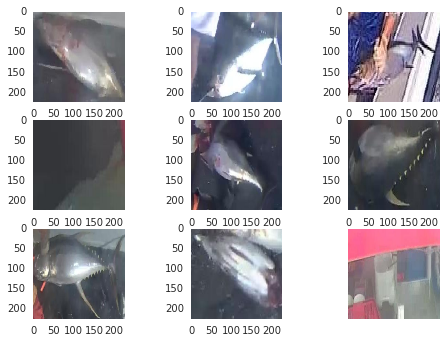

In [69]:
model.visualize_predictions()

Compute accuracy

In [45]:
acc = (np.argmax(predictions, 1) == np.argmax(y_cls_test, 1)).mean()

print "accuracy: ", acc

accuracy:  0.51652892562


In [72]:
model.save_models(cls_name="first_model")